In [45]:
from pref_voting.profiles_with_ties import *
from pref_voting.voting_methods import *
from pref_voting.analysis import *
from pref_voting.generate_profiles import *
from pref_voting.generate_weighted_majority_graphs import *

from pref_voting.utility_profiles import UtilityProfile

from pref_voting.generate_utility_profiles import *
from pref_voting.generate_utility_profiles import *
from pref_voting.utility_methods import *

from pref_voting.spatial_profiles import SpatialProfile
from pref_voting.generate_spatial_profiles import *
from pref_voting.utility_functions import *
from pref_voting.probabilistic_methods import *
from tqdm.notebook import tqdm
import nashpy as nash
import numpy as np
import random2 as random
from multiprocess import Pool, cpu_count, current_process
from numba import njit, float32
import functools

In [46]:
class _Mapping(object): 
    """
    A partial function on a set of items.  
    """
    def __init__(
        self, 
        mapping, # a dictionary representing the mapping
        domain=None, # if domain is None, then it is assumed to be all keys (so mapping is a total function)
        codomain=None, # if codomain is None, then it is assumed to be any number
        compare_function=None, # function used to compare values
        item_map=None, # a dictionary mapping items to their names
        val_map=None, # a dictionary mapping values to their names
        ):
        
        assert domain is None or all([x in domain for x in mapping.keys()]), f"Not all keys in {mapping} are in the domain {domain}."
        
        assert domain is not None or all([isinstance(v, (int, float)) for v in mapping.values()]), f"Not all values in {mapping} are numbers."
        
        assert codomain is None or all([v in codomain for v in mapping.values()]), f"Not all values in {mapping} are in the codomain {codomain}."

        self.mapping = mapping
        self.domain = domain if domain is not None else sorted(list(mapping.keys())) # if domain is None, then it is assumed to be all keys (so mapping is a total function)
        self.codomain = codomain # if codomain is None, then it is assumed to be any number
        self.item_map = item_map if item_map is not None else {x:str(x) for x in self.domain} # a dictionary mapping items in the domain to their names
        self.val_map = (lambda v : "None" if v is None else val_map[v]) if val_map is not None else (lambda v: str(v)) # a function mapping values to their names
        
        self.compare_function = compare_function if compare_function is not None else lambda v1, v2: (v1 > v2) - (v2 > v1)

    def val(self, x): 
        """
        The value assigned to x by the mapping. If x is in the domain but not defined by the mapping, then None is returned.
        """
        assert x in self.domain, f"{x} not in the domain {self.domain}"
        return self.mapping[x] if x in self.mapping.keys() else None

    def has_value(self, x):
        return x in self.mapping.keys()

    @property
    def defined_domain(self):
        return sorted(list(self.mapping.keys()))

    def inverse_image(self, v):
        """Return all the elements in the domain that are mapped to v."""
        return [x for x in self.domain if self.val(x) == v]
        
    def image(self, items=None): 
        """
        The image of the mapping.
        """
        items = self.defined_domain if items is None else items
        return list([self.val(x) for x in items if self.val(x) is not None])

    @property
    def range(self): 
        """
        The range of the mapping.
        """
        return sorted(list(set(self.mapping.values())))

    def average(self, **kwargs): 
        """
        Return the average utility of all elements in alternatives. If alternatives is None, then find the average utility of all elements that are assigned a utility.
        """

        items = kwargs.get("items", None) or kwargs.get("candidates", None) or kwargs.get("alternatives", None)
                
        assert items is None or all([isinstance(self.val(x), (int, float)) or self.val(x) is None for x in items]), "Not all values are numbers."

        img = self.image(items=items)
        return np.mean(img) if len(img) > 0 else None

    def median(self, **kwargs): 
        """
        Return the median utility of all elements in alternatives. If alternatives is None, then find the average utility of all elements that are assigned a utility.
        """

        items = kwargs.get("items", None) or kwargs.get("candidates", None) or kwargs.get("alternatives", None)

        assert items is None or all([isinstance(self.val(x), (int, float)) or self.val(x) is None for x in items]), "Not all values are numbers."

        img = self.image(items=items)
        return np.median(img) if len(img) > 0 else None

    def compare(self, x, y): 
        """
        Return 1 if the value of x is greater than the value of y, 0 if they are equal, and -1 if the value of x is less than the value of y.

        If either x or y is not defined, then None is returned.
        """
        assert x in self.domain, f"{x} not in the domain {self.domain}"
        assert y in self.domain, f"{y} not in the domain {self.domain}"

        return None if (not self.has_value(x) or not self.has_value(y)) else self.compare_function(self.val(x), self.val(y))

    def extended_compare(self, x, y): 
        """
        Return 1 if the value of x is greater than the value of y or x has a value and y does not have a value, 0 if they are equal or both do not have values, and -1 if the value of y is greater than the value of x or y has a value and x does not have a value.

        If either x or y is not defined, then None is returned.
        """
        assert x in self.domain, f"{x} not in the domain {self.domain}"
        assert y in self.domain, f"{y} not in the domain {self.domain}"

        if self.has_value(x) and not self.has_value(y): 
            return 1
        elif self.has_value(y) and not self.has_value(x):
            return -1
        elif not self.has_value(x) and not self.has_value(y):
            return 0
        else:
            return self.compare_function(self.val(x), self.val(y))

    def strict_pref(self, x, y):
        """Returns True if ``x`` is strictly preferred to ``y``.

        The return value is True when both ``x`` and ``y`` are assigned values and the value of ``x`` is strictly greater than the utility of ``y`` according to the compare function.
        """
        return self.compare(x, y) == 1

    def extended_strict_pref(self, x, y):
        """Returns True if ``x`` is strictly preferred to ``y`` using the extended compare function.

        The return value is True when the value of ``x`` is strictly greater than the value of ``y`` or ``x`` is assigned a value and ``y`` is not assigned a value.
        """
        return self.extended_compare(x, y) == 1

    def indiff(self, x, y):
        """Returns True if ``x`` is indifferent with ``y``.

        The return value is True when both ``x`` and ``y`` are assigned values and the value of ``x`` equals the value of ``y``.
        """
        return self.compare(x, y) == 0

    def extended_indiff(self, x, y):
        """Returns True if ``x`` is indifferent with ``y`` using the ``extended_compare`` function.

        The return value is True when the value of ``x`` equals the value of ``y`` or both ``x`` and ``y`` are not assigned values.
        """
        return self.extended_compare(x, y) == 0

    def weak_pref(self, x, y):
        """Returns True if ``x`` is weakly preferred to ``y``.

        The return value is True when both ``x`` and ``y`` are assigned utilities and the utility of ``x`` is at least as  greater than the utility of ``y``.
        """

        return self.strict_pref(x, y) or self.indiff(x, y)

    def extended_weak_pref(self, x, y):
        """Returns True if ``x`` is weakly preferred to ``y``.

        The return value is True when both ``x`` and ``y`` are assigned utilities and the utility of ``x`` is at least as  greater than the utility of ``y``.
        """

        return self.extended_strict_pref(x, y) or self.extended_indiff(x, y)

    def _indifference_classes(self, items, use_extended=False):
        """
        Return a list of the indifference classes of the items.
        """
        indiff_classes = list()
        processed_items = set()
        compare_fnc = self.extended_compare if use_extended else self.compare
        for x in items:
            if x not in processed_items:
                indiff = [y for y in items if compare_fnc(x, y) == 0]
                indiff_classes.append(indiff)
                for y in indiff:
                    processed_items.add(y)
        return indiff_classes

    def sorted_domain(self, extended=False):
        """
        Return a list of the indifference classes sorted according to the compare function (or extended compare function if extended is True).
        """
        indiff_classes = self._indifference_classes(self.domain, use_extended=True) if extended else self._indifference_classes(self.defined_domain)

        compare_fnc = self.extended_compare if extended else self.compare

        key_func = functools.cmp_to_key(lambda xs, ys : compare_fnc(xs[0], ys[0]))

        return sorted(indiff_classes, key=key_func, reverse=True)

    def as_dict(self):
        """
        Return the mapping as a dictionary.
        """
        return {c: self.val(c) for c in self.defined_domain}

    def display_str(self, func_name): 
        """
        Return a string representation of the mapping.
        """
        return f"{', '.join([f'{func_name}({self.item_map[x]}) = {self.val_map(self.val(x))}' for x in self.domain])}"
        
    def __call__(self, x): 
        return self.val(x)

    def __repr__(self): 
        return f"{self.mapping}"
    
    def __str__(self):
        return f'{", ".join([f"{self.item_map[x]}:{self.val_map(self.val(x))}" for x in self.domain])}'

In [47]:
a="a"
b="b"
c="c"
d="d"
e="e"
f="f"
map = _Mapping(
    {a:1, b:3, c:3, d:2}, 
    )

print(map(a))
print(map.val_map(None))
print(map.sorted_domain())
print(map.sorted_domain(extended=True))
print(map)
map = _Mapping(
    {a:1, b:3, c:3, d:2}, 
    domain=[a,b,c,d,e,f], 
    compare_function=lambda v1, v2: (v1 < v2) - (v2< v1),
    val_map={1:"A", 2:"B", 3:"C"})

print(map(a))
print(map.range)
print(map.image())

print(map.sorted_domain())
print(map.sorted_domain(extended=True))
print(map)
print(map.average(candidates=[a, b, d, f, e]))
print(map.median())


map = _Mapping({}, domain=[a,b,c,d,e,f])

print(map)
print(map.average())

1
None
[['b', 'c'], ['d'], ['a']]
[['b', 'c'], ['d'], ['a']]
a:1, b:3, c:3, d:2
1
[1, 2, 3]
[1, 3, 3, 2]
[['a'], ['d'], ['b', 'c']]
[['a'], ['d'], ['b', 'c'], ['e', 'f']]
a:A, b:C, c:C, d:B, e:None, f:None
2.0
2.5
a:None, b:None, c:None, d:None, e:None, f:None
None


In [48]:
class Utility(_Mapping):
    def __init__(self, utils, **kwargs):
        """Constructor method for the Utility class."""

        if "domain" in kwargs and "candidates" in kwargs:
            raise ValueError("You can only provide either 'domain' or 'candidates', not both.")
        if "domain" in kwargs:
            self.domain = kwargs["domain"]
        elif "candidates" in kwargs:
            self.domain = kwargs["candidates"]
        else:
            self.domain = list(utils.keys())

        self.cmap = {x:str(x) for x in self.domain} if "cmap" not in kwargs else kwargs["cmap"]

        assert self.domain is None or all([x in self.domain for x in utils.keys()]), f"The domain {domain} must contain all elements in the utility map {utils}"
        
        super().__init__(utils, domain=self.domain, item_map = self.cmap)

    @property
    def candidates(self):
        return self.domain

    def items_with_util(self, u):
        """Returns a list of the items that are assigned the utility ``u``."""
        return self.inverse_image(u)

    def has_utility(self, x): 
        """Return True if x has a utility."""
        return self.has_value(x)
    
    def remove_cand(self, x):
        """Returns a utility with the item ``x`` removed."""

        new_utils  = {y: self.val(y) for y in self.defined_domain if y != x}
        new_domain = [y for y in self.domain if y != x]
        new_cmap   = {y: self.cmap[y] for y in self.cmap.keys() if y != x}
        return Utility(new_utils, domain=new_domain, cmap=new_cmap)
    
    def to_approval_ballot(self): 
        """
        Return an approval ballot representation of the mapping.  It is assumed that the voter approves of all candidates with a utility greater than or equal to the average of the utilities assigned to the candidates.
        """
        avg_grade = self.average()
        return Grade(
            {
                x: 1 if self.val(x) >= avg_grade else 0 for x in self.defined_domain
            },
            [0, 1],
            candidates=self.domain,
            cmap=self.cmap
        )

    def ranking(self): 
        """Return the ranking generated by this utility function."""

        return Ranking(
            {x:idx + 1 for idx, indiff_class in enumerate(self.sorted_domain()) 
             for x in indiff_class})
    
    def extended_ranking(self): 
        """Return the ranking generated by this utility function."""

        return Ranking(
            {x:idx + 1 for idx, indiff_class in enumerate(self.sorted_domain(extended=True))
             for x in indiff_class})

    def has_tie(self, use_extended=False): 
        """Return True when there are at least two candidates that are assigned the same utility."""
        return any([len(cs) != 1 for cs in self.sorted_domain(extended=use_extended)])

    def is_linear(self, num_cands):
        """Return True when the assignment of utilities is a linear order of ``num_cands`` candidates. 
        """

        return self.ranking().is_linear(num_cands=num_cands)

    def represents_ranking(self, r, use_extended=False): 
        """Return True when the utility represents the ranking ``r``."""
        
        if use_extended: 
            for x in r.cands: 
                for y in r.cands: 
                    if r.extended_strict_pref(x, y) and not self.extended_strict_pref(x, y): 
                        return False
                    elif r.extended_indiff(x, y) and not self.extended_indiff(x, y): 
                        return False

        else:
            for x in r.cands: 
                if not self.has_utility(x):
                    return False
            for x in r.cands: 
                for y in r.cands: 
                    if r.strict_pref(x, y) and not self.strict_pref(x, y): 
                        return False
                    elif r.indiff(x, y) and not self.indiff(x, y): 
                        return False
        return True
    
    def transformation(self, func): 
        """
        Return a new utility function that is the transformation of this utility function by the function ``func``.        
        """
        return Utility({
            x: func(self.val(x)) for x in self.defined_domain
        }, 
        domain = self.domain, 
        cmap=self.cmap)
    
    def linear_transformation(self, a=1, b=0): 
        """Return a linear transformation of the utility function: ``a * u(x) + b``.
        """
        
        lin_func = lambda x: a * self.val(x) + b
        return self.transformation(lin_func)
    
    def normalize_by_range(self): 
        """Return a normalized utility function.  Applies the *Kaplan* normalization to the utility function: 
        The new utility of an element x of the domain is (u(x) - min({u(x) | x in the domain})) / (max({u(x) | x in the domain })).
        """

        max_util = max(self.range)
        min_util = min(self.range)
        
        if max_util == min_util: 
            return Utility(
                {x:0 for x in self.defined_domain}, 
                domain = self.domain, 
                cmap=self.cmap)
        else: 
            return Utility({
                x: (self.val(x) - min_util) / (max_util - min_util) for x in self.defined_domain
            }, 
            domain = self.domain, 
            cmap=self.cmap)
        
    def normalize_by_standard_score(self): 
        """Replace each utility value with its standard score.  The standard score of a value is the number of standard deviations it is above the mean.
        """

        utility_values = np.array(list(self.image()))
    
        mean_utility = np.mean(utility_values)
        std_dev_utility = np.std(utility_values)

        return Utility({
                x: (self.val(x) - mean_utility) / std_dev_utility for x in self.defined_domain
            }, 
            domain = self.domain, 
            cmap=self.cmap)
        
    def expectation(self, prob):
        """Return the expected utility given a probability distribution ``prob``."""

        assert all([x in self.domain for x in prob.keys()]), "The domain of the probability distribution must be a subset of the domain of the utility function."

        return sum([prob[x] * self.util(x) for x in self.domain if x in prob.keys() and self.has_utility(x)])

    def __str__(self):
        return self.display_str("U")

class Grade(_Mapping):
    def __init__(
        self, 
        grade_map, 
        grades, 
        candidates=None, 
        cmap=None, 
        gmap=None, 
        compare_function=None):
        """Constructor method for a Grade function."""

        assert all([g in grades for g in grade_map.values()]), f"All the grades in the grade map {grade_map} must be in the grades {grades}"
        assert candidates is None or all([x in candidates for x in grade_map.keys()]), f"The candidates {candidates} must contain all elements in the grade map {grade_map}"

        self.candidates = sorted(candidates) if candidates is not None else sorted(list(grade_map.keys())) 

        self.cmap = {x:str(x) for x in self.candidates} if cmap is None else cmap

        self.grades = grades 

        self.gmap = {g:str(g) for g in self.grades} if gmap is None else gmap

        super().__init__(
            grade_map, 
            domain=self.candidates, 
            codomain=self.grades, 
            item_map=self.cmap, 
            val_map=self.gmap,
            compare_function=compare_function)

    @property
    def graded_candidates(self):
        """Returns a list of the items that are assigned a grade."""
        return self.defined_domain

    def candidates_with_grade(self, g):
        """Returns a list of the items that are assigned the grade ``g``."""
        return self.inverse_image(g)

    def has_grade(self, x): 
        """Return True if x has a grade."""
        return self.has_value(x)
    
    def remove_cand(self, x):
        """Returns a grade function with the item ``x`` removed."""

        new_grades  = {y: self.val(y) for y in self.defined_domain if y != x}
        new_candidates = [y for y in self.domain if y != x]
        new_cmap   = {y: self.cmap[y] for y in self.cmap.keys() if y != x}
        return Grade(new_grades, grades=self.grades, candidates=new_candidates, cmap=new_cmap, gmap=self.gmap, compare_function=self.compare_function)
    
    def ranking(self): 
        """Return the ranking generated by this grade function."""

        return Ranking(
            {x:idx + 1 for idx, indiff_class in enumerate(self.sorted_domain()) 
             for x in indiff_class})
    
    def extended_ranking(self): 
        """Return the ranking generated by this grade function."""

        return Ranking(
            {x:idx + 1 for idx, indiff_class in enumerate(self.sorted_domain(extended=True))
             for x in indiff_class})

    def has_tie(self, use_extended=False): 
        """Return True when the utility has a tie."""
        return any([len(cs) != 1 for cs in self.sorted_domain(extended=use_extended)])

    def is_linear(self, num_cands):
        """Return True when the assignment of grades is a linear order of ``num_cands`` candidates. 
        """

        return self.ranking().is_linear(num_cands=num_cands)
    
    def __str__(self):
        return self.display_str("grade")



In [49]:
u = Utility({a:-1, b:3, c:3, d:2}, candidates=[a,b,c,d,e,f])

print(u.domain)
print(u(a))
print(u.val(a))
print(u.sorted_domain())
print(u.sorted_domain(extended=True))
print(u)
print(u.has_tie())
print(u.ranking())

print(u.extended_ranking())

print(u.normalize_by_standard_score())
print(u.normalize_by_range())
print(u.transformation(lambda x: x**2))

print(u.to_approval_ballot())

['a', 'b', 'c', 'd', 'e', 'f']
-1
-1
[['b', 'c'], ['d'], ['a']]
[['b', 'c'], ['d'], ['a'], ['e', 'f']]
U(a) = -1, U(b) = 3, U(c) = 3, U(d) = 2, U(e) = None, U(f) = None
True
( b  c ) d a 
( b  c ) d a ( e  f ) 
U(a) = -1.6774842736586515, U(b) = 0.7624928516630234, U(c) = 0.7624928516630234, U(d) = 0.15249857033260467, U(e) = None, U(f) = None
U(a) = 0.0, U(b) = 1.0, U(c) = 1.0, U(d) = 0.75, U(e) = None, U(f) = None
U(a) = 1, U(b) = 9, U(c) = 9, U(d) = 4, U(e) = None, U(f) = None
grade(a) = 0, grade(b) = 1, grade(c) = 1, grade(d) = 1, grade(e) = None, grade(f) = None


In [50]:
g = Grade({a:"A", b:"C", c:"C", d:"B"}, grades=["A", "B", "C"], candidates=[a,b,c,d,e,f])

print(g)
print(g(a))
print(g.ranking())
print(g.graded_candidates)
print(g.candidates)

grade(a) = A, grade(b) = C, grade(c) = C, grade(d) = B, grade(e) = None, grade(f) = None
A
( b  c ) d a 
['a', 'b', 'c', 'd']
['a', 'b', 'c', 'd', 'e', 'f']


In [51]:
g = Grade({a:1, b:0, c:1, d:1}, grades=[0, 1], candidates=[a,b,c,d,e,f])

print(g)
print(g(a))
print(g.ranking())
print(g.extended_ranking())
print(g.graded_candidates)
print(g.candidates)

grade(a) = 1, grade(b) = 0, grade(c) = 1, grade(d) = 1, grade(e) = None, grade(f) = None
1
( a  c  d ) b 
( a  c  d ) b ( e  f ) 
['a', 'b', 'c', 'd']
['a', 'b', 'c', 'd', 'e', 'f']


In [73]:

class GradeProfile(object):
    """An anonymous profile of (truncated) grades.  

    :param grade_maps: List of grades in the profile, where a grade is either a :class:`Grade` object or a dictionary.
    :type grade_maps: list[dict[int or str: int or str]] or list[Grade]
    :param grades: List of grades.
    :type gcounts: list[int or str]
    :param gcounts: List of the number of voters associated with each grade.  Should be the same length as grade_maps.  If not provided, it is assumed that 1 voter submitted each element of ``grade_maps``.
    :type gcounts: list[int], optional
    :param candidates: List of candidates in the profile.  If not provided, it is the candidates that are assigned a grade by least on voter.
    :type candidates: list[int] or list[str], optional
    :param cmap: Dictionary mapping candidates to candidate names (strings).  If not provided, each candidate name is mapped to itself.
    :type cmap: dict[int or str: str], optional
    :param gmap: Dictionary mapping grades to grade names (strings).  If not provided, each grade is mapped to itself.
    :type gmap: dict[int or str: str], optional
    :param grade_order: A list of the grades representing the order of the grades. It is assumed the grades are listed from largest to smallest.  If not provided, the grades are assumed to be numbers and compared using the greater-than relation.
    :type gmap: list[int or str], optional

    :Example:

    The following code creates a profile in which
    2 voters submitted the ranking 0 ranked first, 1 ranked second, and 2 ranked third; 3 voters submitted the ranking 1 and 2 are tied for first place and 0 is ranked second; and 1 voter submitted the ranking in which 2 is ranked first and 0 is ranked second:

    .. code-block:: python

        gprof =  GradeProfile([{"x":1, "y":3, "z":1}, {"x":0, "y":-1, "z":3}, {"x":0, "y":-1}, {"x":0, "y":1, "z":2}], [-1, 0, 1, 2, 3], gcounts=[2, 3, 1, 1], candidates=["x", "y", "z"])

        gprof.display()

    """

    def __init__(
        self, 
        grade_maps, 
        grades, 
        gcounts=None, 
        candidates=None, 
        cmap=None,
        gmap=None,
        grade_order=None):
        """Constructor method"""

        assert gcounts is None or len(grade_maps) == len(
            gcounts
        ), "The number of grades much be the same as the number of gcounts"
        self.candidates = (
            sorted(candidates)
            if candidates is not None
            else sorted(list(set([x for g in grade_maps for x in g.keys()])))
        )
        """The domain of the profile. """
        self.cmap = cmap if cmap is not None else {c: str(c) for c in self.candidates}
        """The candidate map is a dictionary associating an alternative with the name used when displaying a alternative."""

        self.grades=grades
        """The grades in the profile. """

        self.can_sum_grades = all([isinstance(g, (float, int)) for g in self.grades])

        self.grade_order = grade_order if grade_order is not None else sorted(self.grades, reverse = True)
        """The order of the grades. If None, then order from largest to smallest"""

        self.use_grade_order = grade_order is not None

        self.compare_function = lambda v1, v2: (v1 < v2) - (v2 < v1) if grade_order is None else lambda v1, v2: (grade_order.index(v1) < grade_order.index(v2)) - (grade_order.index(v2) < grade_order.index(v1))

        self.gmap = gmap if gmap is not None else {g: str(g) for g in self.grades}
        """The candidate map is a dictionary associating an alternative with the name used when displaying a alternative."""

        self._grades = [
            Grade(g_map, self.grades, candidates=self.candidates, cmap=self.cmap, gmap=self.gmap, compare_function=self.compare_function)
            if type(g_map) == dict
            else Grade(g_map.as_dict(), self.grades, candidates=self.candidates, cmap=self.cmap, gmap=self.gmap, compare_function=self.compare_function)
            for g_map in grade_maps
        ]
        """The list of grades in the Profile (each utility is a :class:`Utility` object). 
        """
        self.gcounts = [1] * len(grade_maps) if gcounts is None else list(gcounts)

        self.num_voters = np.sum(self.gcounts)
        """The number of voters in the profile. """

    @property
    def grades_counts(self):
        """Returns the grade and the counts of each grade."""

        return self._grades, self.gcounts
    
    @property
    def grade_functions(self):
        """Return all of the grade functions in the profile."""
        
        gs = list()
        for g,c in zip(self._grades, self.gcounts): 
            gs += [g] * c
        return gs

    def has_grade(self, c):
        """Return True if ``c`` is assigned a grade by at least one voter."""

        return any([g.has_grade(c) for g in self._grades])

    def margin(self, c1, c2, use_extended=False): 
        """
        Return the margin of ``c1`` over ``c2``.  If ``c1`` is not assigned a grade by any voter, return None.
        """
        if use_extended: 
            return np.sum([num for g,num in zip(*self.grades_counts) if g.extended_strict_pref(c1, c2)]) - np.sum([num for g,num in zip(*self.grades_counts) if g.extended_strict_pref(c2, c1)])
        else: 
            return np.sum([num for g,num in zip(*self.grades_counts) if g.strict_pref(c1, c2)]) - np.sum([num for g,num in zip(*self.grades_counts) if g.strict_pref(c2, c1)])

    def proportion(self, cand, grade):
        """
        Return the proportion of voters that assign ``cand`` the grade ``grade``.

        Note that ``grade`` could be None, in which case the proportion of voters that do not assign ``cand`` a grade is returned.
        """
        return np.sum([num for g,num in zip(*self.grades_counts) if g(cand) == grade]) / self.num_voters

    def sum(self, c): 
        """Return the sum of the grades of ``c``.  If ``c`` is not assigned a grade by any voter, return None."""

        assert self.can_sum_grades, "The grades in the profile cannot be summed."

        return np.sum([g(c) * num for g,num in zip(*self.grades_counts) if g.has_grade(c)]) if self.has_grade(c) else None
    
    def avg(self, c): 
        """Return the average of the grades of ``c``.  If ``c`` is not assigned a grade by any voter, return None."""

        assert self.can_sum_grades, "The grades in the profile cannot be summed."

        return np.mean([g(c) for g in self.grade_functions if g.has_grade(c)]) if self.has_grade(c) else None
    
    def max(self, c): 
        """Return the maximum of the grade of ``c``.  If ``c`` is not assigned a grade by any voter, return None."""

        grades_for_c = [-1 * self.grade_order.index(g(c)) for g in self._grades if g.has_grade(c)] if self.use_grade_order else [g(c) for g in self._grades if g.has_grade(c)]

        return (self.grade_order[-1 * max(grades_for_c)] if self.use_grade_order else max(grades_for_c)) if self.has_grade(c) else None
    
    def min(self, c): 
        """Return the minimum of the grades of ``c``.  If ``c`` is not assigned a grade by any voter, return None."""

        grades_for_c = [-1 * self.grade_order.index(g(c)) for g in self._grades if g.has_grade(c)] if self.use_grade_order else [g(c) for g in self._grades if g.has_grade(c)]

        return (self.grade_order[-1 * min(grades_for_c)] if self.use_grade_order else min(grades_for_c)) if self.has_grade(c) else None
    
    def median(self, c, use_lower=True, use_average=False): 
        """Return the median of the grades of ``c``.  If ``c`` is not assigned a grade by any voter, return None."""

        grades_for_c = [-1 * self.grade_order.index(g(c)) for g in self.grade_functions if g.has_grade(c)] if self.use_grade_order else [g(c) for g in self.grade_functions if g.has_grade(c)]

        sorted_grades_for_c = sorted(grades_for_c)
        num_grades = len(sorted_grades_for_c)
        median_idx = num_grades // 2
        if num_grades % 2 == 0:
            median_grades = sorted_grades_for_c[median_idx - 1:median_idx + 1]
        else:
            median_grades = [sorted_grades_for_c[median_idx]]

        if use_lower:
            return (self.grade_order[-1 * median_grades[0]] if self.use_grade_order else median_grades[0]) if self.has_grade(c) else None
        elif average_ties:
            return (np.average([self.grade_order[-1 * m] for m in median_grades]) if self.use_grade_order else np.average(median_grades)) if self.has_grade(c) else None
        else:
            return ([self.grade_order[-1 * m] for m in median_grades] if self.use_grade_order else median_grades) if self.has_grade(c) else None

    def sum_grade_function(self):
        """Return the sum grade function of the profile."""

        assert self.can_sum_grades, "The grades in the profile cannot be summed."

        return _Mapping(
            {
                c: self.sum(c)
                for c in self.candidates if self.has_grade(c)
            },
            domain=self.candidates, 
            item_map=self.cmap, 
            compare_function=self.compare_function
        )
    def avg_grade_function(self):
        """Return the average grade function of the profile."""

        assert self.can_sum_grades, "The grades in the profile cannot be summed."

        return _Mapping(
            {
                c: self.avg(c)
                for c in self.candidates if self.has_grade(c)
            },
            domain=self.candidates, 
            item_map=self.cmap, 
            compare_function=self.compare_function
        )

    def to_ranking_profile(self): 
        """Return a ranking profile (a :class:ProfileWithTies) corresponding to the profile."""

        return ProfileWithTies(
            [g.ranking() for g in self._grades],
            rcounts = self.gcounts,
            candidates = self.candidates, 
            cmap = self.cmap
        )
    
    def write(self):
        """Write the profile to a string."""

        gprof_str = f"{len(self.candidates)};{self.num_voters};{self.grades}"
        for g in self.grade_functions: 
            g_str = ''
            for c in g.graded_candidates: 
                g_str += f"{c}:{g(c)},"
            gprof_str += f";{g_str[0:-1]}"
        return str(gprof_str)

    @classmethod
    def from_string(cls, gprof_str): 
        """
        Returns a profile of utilities described by ``gprof_str``.

        ``gprof_str`` must be in the format produced by the :meth:`pref_voting.GradeProfile.write` function.
        """
        gprof_data = gprof_str.split(";")

        num_alternatives,num_voters,grades = int(gprof_data[0]),int(gprof_data[1]),gprof_data[2:]

        grade_maps = [{int(cg.split(":")[0]): float(cg.split(":")[1]) for cg in gs.split(",")} if gs != '' else {} for gs in grades]

        if len(grade_maps) != num_voters: 
            raise Exception("Number of voters does not match the number of utilities.")
        
        return cls(grade_maps, candidates=range(num_alternatives))

    def display(self, show_totals=False, average_median_ties=False):
        """Display a grade profile as an ascii table (using tabulate). If ``show_totals`` is true then the sum, min, and max of the grades are displayed.

        """
                        
        if show_totals:
            sum_grade_fnc = self.sum_grade_function()
            headers = [''] + self.gcounts + ["Sum", "Median"]
            tbl = [[self.cmap[c]] + [self.gmap[g(c)] if g.has_grade(c) else "" for g in self._grades] + [sum_grade_fnc(c), self.median(c)] for c in self.candidates]
 
        else: 
            headers = [''] + self.gcounts
            tbl = [[self.cmap[c]] + [self.gmap[g(c)] if g.has_grade(c) else "" for g in self._grades] for c in self.candidates]
            # tbl ={"" : self.gcounts}
            # tbl.update({str(c): [g(c) for g in self._grades] for c in self.candidates})
        print(tabulate(tbl, headers=headers))

    def visualize(self):
        """Visualize a grade profile as a stacked bar plot."""
        data_for_df = {
            'Candidate': [],
            'Grade': [],
            'Proportion': []
        }

        for c in self.candidates: 
            for g in [None] + self.grades:
                data_for_df['Candidate'].append(self.cmap[c])
                data_for_df['Grade'].append(self.gmap[g] if g is not None else "None")
                data_for_df['Proportion'].append(self.proportion(c, g))
        df = pd.DataFrame(data_for_df)

        # Pivot the DataFrame to organize it for the stacked bar plot
        df_pivot = df.pivot(index='Candidate', columns='Grade', values='Proportion')

        df_pivot
        # # Create the stacked bar plot
        ax = df_pivot.plot(kind='barh', stacked=True, figsize=(10, 6), rot=0)
        ax.set_ylabel('Candidate')
        ax.set_xlabel('Proportion')
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)
        # Show the plot

        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(self.grades) + 1, title="Grades")

        plt.show()


In [74]:
gprof = GradeProfile(
    [{a:1, b:2, c:3, d:1},
    {a:3, b:1, c:1, d:2},
    {d:3, a:3, b:3, c:3},
    {a:1, b:1, c:2, d:4}],
    [1, 2,3, 4],
    gcounts=[2, 3, 1, 2],
    candidates=[a, b, c, d]
)

print(gprof.grades)
gprof.write()
gprof.display(show_totals=True, average_median_ties=False)

print(gprof.margin(a, b))
print(gprof.margin(a, d, use_extended=True))

prof = gprof.to_ranking_profile()
prof.display()

[1, 2, 3, 4]
      2    3    1    2    Sum    Median
--  ---  ---  ---  ---  -----  --------
a     1    3    3    1     16         1
b     2    1    3    1     12         1
c     3    1    3    2     16         2
d     1    2    3    4     19         2
-1
-1
+-----+-----+---------+-----+
|  2  |  3  |    1    |  2  |
+-----+-----+---------+-----+
| a d | b c | a b c d | a b |
|  b  |  d  |         |  c  |
|  c  |  a  |         |  d  |
|     |     |         |     |
+-----+-----+---------+-----+


In [75]:
print(gprof.candidates)

['a', 'b', 'c', 'd']


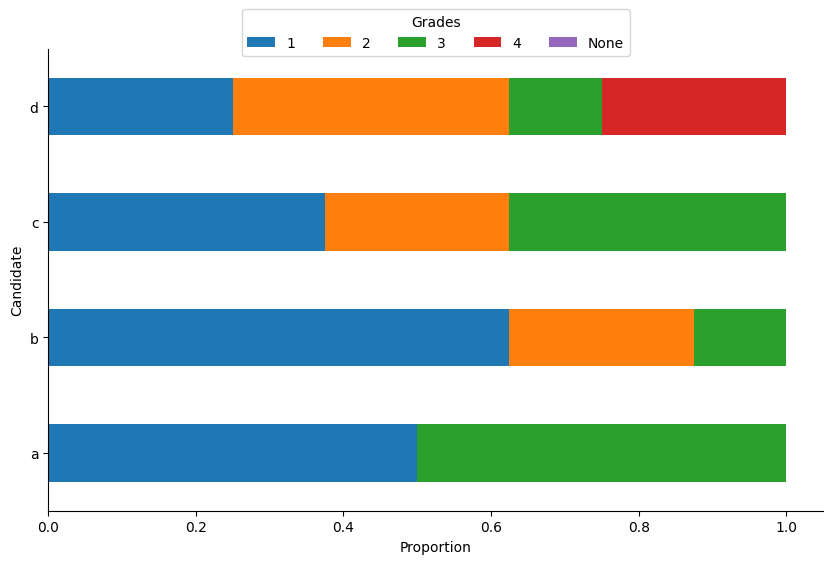

In [76]:
gprof.visualize()

In [77]:
def score_vote(gprofile, curr_cands=None):
    """Return the candidates with the largest sum of the scores.  If ``curr_cands`` is provided, then the score vote is restricted to the candidates in ``curr_cands``.
    """
    
    curr_cands = gprofile.candidates if curr_cands is None else curr_cands
    
    scores = {
        c: gprofile.sum(c) 
        for c in curr_cands if gprofile.has_grade(c)
        }

    max_score = max(scores.values())

    return sorted([c for c in scores.keys() if scores[c] == max_score])

def approval_vote(gprofile, curr_cands=None):
    """Return the approval vote of the grade profile ``gprofile``.  If ``curr_cands`` is provided, then the approval vote is restricted to the candidates in ``curr_cands``.
    """
    assert sorted(gprofile.grades) == [0, 1], "The  grades in the profile must be {0, 1}."
    
    return score_vote(gprofile, curr_cands=curr_cands)

In [78]:
def star_vote(gprofile, curr_cands=None):
    """Identify the top two candidates according to the sum of the grades for each candidate. Then hold a runoff between the top two candidates where the candidate that is ranked above the other by the most voters is the winner.  The candidates that move to the runoff round are: the candidate(s) with the largest sum of the grades and the candidate(s) with the 2nd largest sum of the grades (or perhaps tied for the largest sum of the grades). In the case of multiple candidates tied for the largest or 2nd largest sum of the grades, use parallel-universe tiebreaking: a candidate is a Star Vote winner if it is a winner in some head-to-head runoff as described. If the candidates are all tied for the  largest sum of the grades, then all candidates are winners.
    
    If ``curr_cands`` is provided, then the winners is restricted to the candidates in ``curr_cands``.

    .. warning:: 
        Star Vote only works on Grade Profiles that are based on 6 grades: 0, 1, 2, 3, 4, and 5.
    """

    assert sorted(gprofile.grades) == [0, 1, 2, 3, 4, 5], "The  grades in the profile must be {0, 1, 2, 3, 4, 5}."

    curr_cands = gprofile.candidates if curr_cands is None else curr_cands

    if len(curr_cands) == 1: 
        return list(curr_cands)

    cand_to_scores = {
        c: gprofile.sum(c) 
        for c in curr_cands if gprofile.has_grade(c)
        }
    
    scores = sorted(list(set(cand_to_scores.values())), reverse=True)

    max_score = scores[0]
    first = [c for c in cand_to_scores.keys() if cand_to_scores[c] == max_score]

    second = list()
    if len(first) == 1:
        second_score = scores[1]
        second = [c for c in cand_to_scores.keys() if cand_to_scores[c] == second_score]

    if len(second) > 0:
        all_runoff_pairs = product(first, second)
    else: 
        all_runoff_pairs = [(c1,c2) for c1,c2 in product(first, first) if c1 != c2]

    winners = list()
    for c1, c2 in all_runoff_pairs: 
        
        if gprofile.margin(c1,c2) > 0:
            winners.append(c1)
        elif gprofile.margin(c1,c2) < 0:
            winners.append(c2)
        elif gprofile.margin(c1,c2) == 0:
            winners.append(c1)
            winners.append(c2)
    
    return sorted(list(set(winners)))


In [79]:
class UtilityProfile(object):
    """An anonymous profile of (truncated) utilities.  

    :param utilities: List of utilities in the profile, where a utility is either a :class:`Utility` object or a dictionary.
    :type utilities: list[dict[int or str: float]] or list[Utility]
    :param ucounts: List of the number of voters associated with each utility.  Should be the same length as utilities.  If not provided, it is assumed that 1 voters submitted each element of ``utilities``.
    :type ucounts: list[int], optional
    :param domain: List of alternatives in the profile.  If not provided, it is the alternatives that are assigned a utility by least on voter.
    :type domain: list[int] or list[str], optional
    :param cmap: Dictionary mapping alternatives to alternative names (strings).  If not provided, each alternative name is mapped to itself.
    :type cmap: dict[int or str: str], optional

    :Example:

    The following code creates a profile in which
    2 voters submitted the ranking 0 ranked first, 1 ranked second, and 2 ranked third; 3 voters submitted the ranking 1 and 2 are tied for first place and 0 is ranked second; and 1 voter submitted the ranking in which 2 is ranked first and 0 is ranked second:

    .. code-block:: python

        uprof =  UtilityProfile([{"x":1, "y":3, "z":1}, {"x":0, "y":-1, "z":4}, {"x":0.5, "y":-1}, {"x":0, "y":1, "z":2}], ucounts=[2, 3, 1, 1], domain=["x", "y", "z"])

    """

    def __init__(self, utilities, ucounts=None, domain=None, cmap=None):
        """Constructor method"""

        assert ucounts is None or len(utilities) == len(
            ucounts
        ), "The number of utilities much be the same as the number of ucounts"

        self.domain = (
            sorted(domain)
            if domain is not None
            else sorted(list(set([x for u in utilities for x in u.keys()])))
        )
        """The domain of the profile. """

        self.cmap = cmap if cmap is not None else {c: str(c) for c in self.domain}
        """The candidate map is a dictionary associating an alternative with the name used when displaying a alternative."""

        self._utilities = [
            Utility(u, domain = self.domain, cmap=self.cmap)
            if type(u) == dict
            else Utility(u.as_dict(), domain=self.domain, cmap=self.cmap)
            for u in utilities
        ]
        """The list of utilities in the Profile (each utility is a :class:`Utility` object). 
        """

        self.ucounts = [1] * len(utilities) if ucounts is None else list(ucounts)

        self.num_voters = np.sum(self.ucounts)
        """The number of voters in the profile. """

    @property
    def utilities_counts(self):
        """Returns the utilities and the counts of each utility."""

        return self._utilities, self.ucounts
    
    @property
    def utilities(self):
        """Return all of the utilities in the profile."""
        
        us = list()
        for u,c in zip(self._utilities, self.ucounts): 
            us += [u] * c
        return us


    def normalize_by_range(self): 
        """Return a profile in which each utility is normalized by range."""
        
        return UtilityProfile([
            u.normalize_by_range() for u in self._utilities
        ], ucounts = self.ucounts, domain = self.domain, cmap=self.cmap)
    
    def normalize_by_standard_score(self):
        """Return a profile in which each utility is normalized by standard scores.
        """
        return UtilityProfile([
            u.normalize_by_standard_score() for u in self._utilities
        ], ucounts = self.ucounts, domain = self.domain, cmap=self.cmap)

    def has_utility(self, x):
        """Return True if ``x`` is assigned a utility by at least one voter."""

        return any([u.has_utility(x) for u in self._utilities])

    def util_sum(self, x): 
        """Return the sum of the utilities of ``x``.  If ``x`` is not assigned a utility by any voter, return None."""

        return np.sum([u(x) * c for u,c in zip(*self.utilities_counts) if u.has_utility(x)]) if self.has_utility(x) else None
    
    def util_avg(self, x): 
        """Return the sum of the utilities of ``x``.  If ``x`` is not assigned a utility by any voter, return None."""

        return np.average([u(x) * c for u,c in zip(*self.utilities_counts) if u.has_utility(x)]) if self.has_utility(x) else None
    
    def util_max(self, x): 
        """Return the maximum of the utilities of ``x``.  If ``x`` is not assigned a utility by any voter, return None."""

        return max([u(x)  for u in self._utilities if u.has_utility(x)]) if self.has_utility(x) else None
    
    def util_min(self, x): 
        """Return the minimum of the utilities of ``x``.  If ``x`` is not assigned a utility by any voter, return None."""

        return min([u(x)  for u in self._utilities if u.has_utility(x)]) if self.has_utility(x) else None

    def sum_utility_function(self):
        """Return the sum utility function of the profile."""

        return Utility(
            {
                x: self.util_sum(x)
                for x in self.domain
            },
            domain=self.domain,
        )
    def avg_utility_function(self):
        """Return the average utility function of the profile."""

        return Utility(
            {
                x: np.average([u(x) for u in self.utilities])
                for x in self.domain
            },
            domain=self.domain,
        )
    
    def to_ranking_profile(self): 
        """Return a ranking profile (a :class:ProfileWithTies) corresponding to the profile."""

        return ProfileWithTies(
            [u.ranking() for u in self._utilities],
            rcounts = self.ucounts,
            candidates = self.domain, 
            cmap = self.cmap
        )
    
    def to_approval_profile(self):
        """
        Return a GradeProfile with each utility transformed to an approval ballot.
        """

        return GradeProfile(
            [u.to_approval_ballot() for u in self._utilities],
            [0, 1],
            gcounts = self.ucounts,
            candidates = self.domain,
            cmap = self.cmap
        )
        
    def write(self):
        """Write the profile to a string."""

        uprof_str = f"{len(self.domain)};{self.num_voters}"
        for u in self.utilities: 
            u_str = ''
            for c in u.domain: 
                if u.has_utility(c):
                    u_str += f"{c}:{u(c)},"
            uprof_str += f";{u_str[0:-1]}"
        return str(uprof_str)

    @classmethod
    def from_string(cls, uprof_str): 
        """
        Returns a profile of utilities described by ``uprof_str``.

        ``uprof_str`` must be in the format produced by the :meth:`pref_voting.UtilityProfile.write` function.
        """
        uprof_data = uprof_str.split(";")

        num_alternatives,num_voters,utilities = int(uprof_data[0]),int(uprof_data[1]),uprof_data[2:]

        util_maps = [{int(cu.split(":")[0]): float(cu.split(":")[1]) for cu in utils.split(",")} if utils != '' else {} for utils in utilities]

        if len(util_maps) != num_voters: 
            raise Exception("Number of voters does not match the number of utilities.")
        
        return cls(util_maps, domain=range(num_alternatives))

    def display(self, vmap = None, show_totals=False):
        """Display a utility profile as an ascii table (using tabulate). If ``show_totals`` is true then the sum, min, and max of the utilities are displayed.

        """
        
        utilities = self.utilities
        
        vmap = vmap if vmap is not None else {vidx: str(vidx + 1) for vidx in range(len(utilities))}
        voters = range(len(utilities))
        
        if show_totals: 
            tbl ={"Voter" : [vmap[v] for v in voters] + [SEPARATING_LINE] + ["Sum", "Min", "Max"]}
            tbl.update({self.cmap(x): [utilities[v](x) for v in voters] + [SEPARATING_LINE] + [self.util_sum(x), self.util_min(x), self.util_max(x)] for x in self.domain})
        else: 
            tbl ={"Voter" : [vmap[v] for v in voters]}
            tbl.update({str(x): [utilities[v](x) for v in voters] for x in self.domain})
        print( tabulate(tbl, headers="keys"))



In [81]:
uprof =  UtilityProfile([{"x":1, "y":3, "z":1}, {"x":0, "y":-1, "z":4}, {"x":0.5, "y":-1}, {"x":0, "y":1, "z":2}], ucounts=[1,1,1,1], domain=["x", "y", "z"])

uprof.display(show_totals=False)
print()
uprof.to_approval_profile().display(show_totals=True)


  Voter    x    y    z
-------  ---  ---  ---
      1  1      3    1
      2  0     -1    4
      3  0.5   -1
      4  0      1    2

      1    1  1      1    Sum    Median
--  ---  ---  ---  ---  -----  --------
x     0    0  1      0      1         0
y     1    0  0      1      2         0
z     0    1         1      2         1
